# Least Squares Approximation Proposal

## Motivation

For a general linear system, let matrix $\textbf{A} \in M_{nxm}(R)$ and vector $\vec{b}\in \mathbb{R}^n$, we cannot always guarantee a solution $\vec{x}$ exists such that $\textbf{A}\vec{x} = \vec{b}$. However, is there a solution $\vec{x}$ such that $||\textbf{A}\vec{x}- \vec{b}||$ is as small as possible (i.e. the error/distance between our solution and the truth is as small as possible)? 

Yes, we can guarantee such an optimal solution with Least Squares Approximation.

## Definitions

We will be using the following definitions and notations in our writeup:

- Let $U\subset V$ be a finite dimensional subspace of some vector space V. 
- The Orthogonal Projection of $V$ onto $U$ is the linear transformation:

$$
proj_U: V \rightarrow V
\newline 
\vec{v} \rightarrow \vec{v}^{\parallel}

\newline

\text{where }\vec{v}^{\parallel}\text{ and }\vec{v}-\vec{v}^{\parallel}\in U^{\perp}
$$


## Theorem (1)

Let $U\subset V$ be as defined and $\overrightarrow{v}\in V$ Then,

$$
||\vec{v}-proj_U(\vec{v})|| \leq ||\vec{v}-\vec{u}|| \text{ for all } \vec{u} \in U
$$

Proof:

## Theoerm (2)

This answers our motivational question. The least squares solutions to the linear systerm $\textbf{A}\vec{x} = \vec{b}$ are the solutions to the linear system,

$$
(\textbf{A}^T\textbf{A})\vec{x}=\textbf{A}^T\vec{b}
$$

Proof:

## Application of Least Square Solutions on Real Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import math

/var/folders/g2/_vml05q979nckwnglt908jqc0000gn/T/ipykernel_47930/2116182443.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Before we begin, we will import the data we will be using.

In [2]:
data = pd.read_csv("./data/2015.csv")
data_nona = data.dropna()
data_clean = data_nona.filter(['Country','Happiness Score','Economy (GDP per Capita)','Freedom'], axis=1)

# standardize the variables of interest
data_clean["Economy (GDP per Capita)"] = data_clean["Economy (GDP per Capita)"]/2
data_clean["Happiness Score"] = data_clean["Happiness Score"]/10

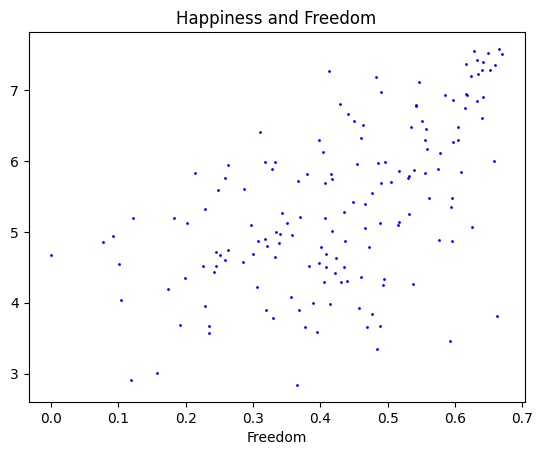

In [3]:
# Create a figure and subplots
fig, (ax1) = plt.subplots(1, 1)

# Plot subplot 2
ax1.scatter(data_clean['Freedom'], data_clean['Happiness Score'], color='b', s=1)
ax1.set_title("Happiness and Freedom")
ax1.set_xlabel('Freedom')

# Show plot
plt.show()

## 1D interpolation GDP and Happiness

In [4]:
def create_Matrix(points):
    rows = []
    for p in points:
        row = []
        for i in range(len(points)):
            row.append(p**i)
        rows.append(row)
    M = np.array(rows)
    return M

In [5]:
A_1d = create_Matrix(data_clean["Freedom"])
y = data_clean["Happiness Score"]

In [6]:
coefficients = np.matmul(np.linalg.inv(A_1d),y)

In [7]:
def y_hat(x, coefficients):
    yhat = 0
    count = 0
    for a in coefficients:
        yhat += a * (x**count)
        count += 1
    return yhat

In [8]:
print(y_hat(data_clean["Freedom"][5], coefficients))
data_clean["Happiness Score"][5]

500.9775390625


7.406

In [9]:
z_hat1d = np.matmul(A_1d, coefficients)

In [10]:
error = np.sum((data_clean["Happiness Score"] - z_hat1d) ** 2)
error/158

119027.58136750245

## 2D Piecewise Bilinear Interpolation

Taking a step further, we can add another variable in our function. Where $g:(x,y) \rightarrow z$. Keeping x as the `Freedom` of a Country, we can add an additional variable `Economy (GDP per Capita)` as y.

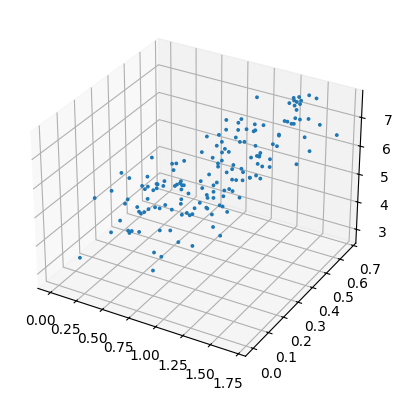

In [11]:
# Create a 3D axis
fig = plt.figure()
ax = plt.axes(projection='3d')

# Plot 3D scatter plot
ax.scatter3D(data_clean['Economy (GDP per Capita)'], data_clean['Freedom'], data_clean['Happiness Score'], s=3, alpha = 1)

# Show plot
plt.show()

Similar to the problem we faced in the 1-dimensional case, a polynomial interpolation will generate an extremely bizzare estimation of the true function due to the number of data points. One way we can get around this problem is using a piecewise approach much like the one we do in cubic splines. However, in order to reduce the complexity of the problem, we will simply implement a 2D piecewise bilinear interpolation.

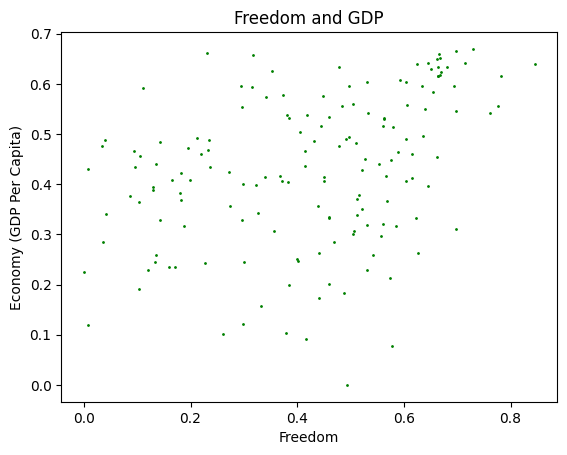

In [24]:
# Create a figure and subplots
fig, (ax1) = plt.subplots(1, 1)

# grid plot

ax1.scatter(data_clean['Economy (GDP per Capita)'], data_clean['Freedom'], color='g', s=1)
ax1.set_title("Freedom and GDP")
ax1.set_ylabel('Economy (GDP Per Capita)')
ax1.set_xlabel('Freedom')

# Show plot
plt.show()

In order to create a piecewise condition for our 2d interpolation, we must divide up the (x, y) plane into the desired grids (pieces). Looking at the x and y variables, we can see that `Freedom` $\in (0,1)$ and `Economy (GDP per Capita)` $\in (0,1)$ after our initial standardization. Then for n-uniform grids, we would need $\sqrt{n}$ intervals on the x and y axis. Then, the grids would just need to be the permutations of these intervals.

For now, we will proceed with 16-uniform grids, i.e.

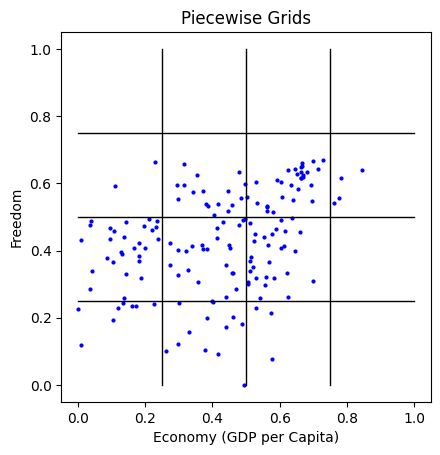

In [13]:
# Plot the grid lines
plt.plot([0, 0], [1, 1], color='black', linestyle='-', linewidth=1)  # horizontal line
plt.plot([1, 1], [0, 0], color='black', linestyle='-', linewidth=1)  # vertical line

# Plot the points
plt.scatter(data_clean['Economy (GDP per Capita)'], data_clean['Freedom'], color='blue', label='Points', s=4)

# Add labels and title
plt.xlabel('Economy (GDP per Capita)')
plt.ylabel('Freedom')
plt.title('Piecewise Grids')

# Define the number of points and grid size
num_points = 3
grid_size = 1 / (num_points + 1)

# Generate grid points
x_points = np.linspace(grid_size, 1 - grid_size, num_points)
y_points = np.linspace(grid_size, 1 - grid_size, num_points)

# Plot the grid lines
for x in x_points:
    plt.plot([x, x], [0, 1], color='black', linestyle='-', linewidth=1)

for y in y_points:
    plt.plot([0, 1], [y, y], color='black', linestyle='-', linewidth=1)

# Set aspect ratio to equal
plt.gca().set_aspect('equal', adjustable='box')

# Show the plot
plt.show()

In [14]:
# create a piecewise 2d-interpolation

# firstly, we need to define a grid that the pieces are defined by.

def create_ngrids(n, xrange, yrange): 
    # n: the number of grids aross one axis i.e. sqrt(total # of grids)
    # xrange: domain of x values
    # yrange: domain of y values

    # initialize the grid points
    x = []
    y = []

    # find the step value k
    xdiff = (xrange[1]- xrange[0])/n
    ydiff = (yrange[1]- yrange[0])/n

    # iteratively find all corners of the grids
    for k in range(n+1):
        x.append(xrange[0] + k * xdiff)
        y.append(yrange[0] + k * ydiff)
    
    # find the 4 corner points of each grid iteratively
    grid = []
    counter = 0 

    # start from the bottom left going up and then move towards the right
    for i in range(n):
        for j in range(n):
            grid.append({ (counter, counter % n) : [(x[i], y[j]), (x[i+1], y[j]), (x[i+1], y[j+1]), (x[i], y[j+1])]})
            counter += 1
    
    # -> grid: 2D array of the grids order going left to right and bottom to top
    return grid

In order to match the data into their respective grids, we will introduce the indicator function,

$$ \mathbb{1}_{G_{i,j}}(x, y) = 
\begin{cases} 
1 & \text{if } (x,y) \in G_{i,j} \\
0 & \text{otherwise}
\end{cases}
$$

where k = 1/4 and $G_{i,j} = \{x\in (ik, ik + k),y \in(jk, jk + k)\}$ for all $i,j$ = 0, 1, 2, 4

It follows that for a bivariate bilinear interpolation, the following condition must hold;

$$
f(x,y) = P(x,y) = a + bx + cy+dxy
$$

where a, b, c, and d are arbitrary constants.

Extending such a function onto all 9 uniform grids we get the following system of equations,

$$
f_{0,0}(x,y) = \mathbb{1}_{G_{0,0}}(x, y) (a_{00} + b_{00}x + c_{00}y+d_{00}xy) \newline
f_{0,1}(x,y) = \mathbb{1}_{G_{0,1}}(x, y) (a_{01} + b_{01}x + c_{01}y+d_{01}xy) \newline
\vdots \newline
f_{3,3}(x,y) = \mathbb{1}_{G_{3,3}}(x, y) (a_{33} + b_{33}x + c_{33}y+d_{33}xy) \newline
$$

Equivalently, $\textbf{A}\vec{\beta} = \vec{z}$ where $\bold{A}$ is the matrix,

$$
\textbf{A} = \begin{pmatrix}
\mathbb{1}_{G_{0,0}} & \mathbb{1}_{G_{0,0}}x & \mathbb{1}_{G_{0,0}}y & \mathbb{1}_{G_{0,0}}xy\\
\mathbb{1}_{G_{0,1}} & \mathbb{1}_{G_{0,1}}x & \mathbb{1}_{G_{0,1}}y & \mathbb{1}_{G_{0,1}}xy\\
\vdots & \vdots & \vdots & \vdots\\
\mathbb{1}_{G_{3,3}} & \mathbb{1}_{G_{3,3}}x & \mathbb{1}_{G_{3,3}}y & \mathbb{1}_{G_{3,3}}xy\\
\end{pmatrix},
$$

$$
\vec{\beta} = [a_{00}, b_{00}, c_{00},d_{00}, a_{01}, \dots , d_{33}]^T,
$$

$$
\text{and }\vec{z} = [f_0(x,y), \dots , f_{158}(x,y)]^T
$$


However, after expanding $\textbf{A}\in M_{158x40}(\mathbb{R})$ and $\vec{\beta}\in \mathbb{R}^{40} \implies$ this is an ill-posed problem. In other words, we cannot gaurantee that an unique solution $\vec{\beta}$ exists. However, by theorem (1), we can approximate the best least-squares solution $\vec{\beta^*}$ for the problem such that, 

$$

||f(x,y)-\textbf{A}(\vec{\beta^*})|| \leq ||f(x,y)-\textbf{A}(\vec{\gamma})|| \text{ for all } \vec{\gamma} \in \mathbb{R}^{40}

$$

Side note, the reason why the the number of columns and the number of variables is 40 rather than 4*16 = 64 is because, notice, 6 of the grids do not contain any data points thus their indicator function is just 0.

In [15]:
# fit the points into the grids

collections = []

# make the 16 grids with the above function
grids = create_ngrids(4, [0,1], [0,1])

# sset aside a grid variable for the grids that actually contains values
new_grids = []

for grid in grids:
    # keep track of the data points in the grids
    data_points = []
    # iterate trough the points of the dataset
    for i in range(data_clean.shape[0]):
        x = data_clean.iloc[i, 2]
        y = data_clean.iloc[i, 3]
        t = list(grid.values())[0]
        # if the point meets the conditions of the indicator function add it to that grid
        if (t[0][0] <= x < t[1][0]) and (t[0][1] <= y < t[2][1]):
            data_points.append((x, y))
    # if a grid has atleast one point, add the point(s) as an array to the collection; add grid to new_grids with same index as points
    if len(data_points) > 0:
        collections.append(data_points)
        new_grids.append(grid)

# remove all null grids
grids = new_grids


In [16]:
# because we moved the points around after arranging them into grids; we need to move their outputs into the same order
rearranged_output = []

# check each index and match the outputs to that index as well
for points in collections:
    for point in points:
        rearranged_output.append(data_clean.loc[(data_clean['Economy (GDP per Capita)'] == point[0]) & (data_clean['Freedom'] == point[1])]["Happiness Score"].values[0])

# store as np.array for computational speed
rearranged_output = np.asarray(rearranged_output)

In [17]:
# Create matrix of data

# Now we want to create the A matrix in code. I will create the A matrix for each grid independently and append them as a "big" diagonal matrix.
def create_AMatrix(points):
    rows = []
    for p in points:
        # each row is of [1, x, y, xy]
        rows.append([1,p[0], p[1], (p[0])*p[1]])
    M = np.array(rows)
    return M

# array of all the matrices that will go down the diagonal
diag_matrices = []
for points in collections:
        diag_matrices.append(create_AMatrix(points))


In [18]:
from scipy.sparse import block_diag

# I will simply use a scipy function to finish creating the "big" diagonal matrix, or our A matrix (https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.block_diag.html)
A = block_diag(diag_matrices)
A = A.toarray()


Since our matrix is not complex and its dimensions are computable, we can directly use theorem (2) to find the least squares solution by computing, 

$\vec{\beta^*} = (\textbf{A}^T \textbf{A})^{-1} \textbf{A}^T \vec{z}$


In [19]:
# Matrix multiplication of A^T and A
H = np.matmul(A.transpose(),A)

# finding our beta by multiplying the inverse on both sides
betastar = np.matmul(np.linalg.inv(H), np.matmul(A.transpose(), rearranged_output))

print(f"By theroem (2): B^* = {betastar}")

By theroem (2): B^* = [  0.14845018  -1.48193474   1.29716202   5.02295651   0.55464567
  -0.72507756  -0.38462542   2.25520443   0.5         -2.
   0.375        0.           0.39509863   0.1060194   -0.22380816
   1.04623835   0.92168939  -1.11027546  -1.40653905   3.70773272
   1.74432429  -3.81698308  -2.296033     7.30919222   2.5
  -3.          -2.           3.          -2.26393304   4.54941758
   6.9259773  -10.97977349  -0.78947154   1.4418781    2.14287895
  -1.9349944   15.95962861 -20.59411142 -22.49190963  30.5052256 ]


However, $\vec{\beta^*}$ alone does not really say much about the approximation. Let's plot the 2D piecewise bilinear planes to see how the estimation did in reality. Below is a plot of $\textbf{A}\vec{\beta^*}$;

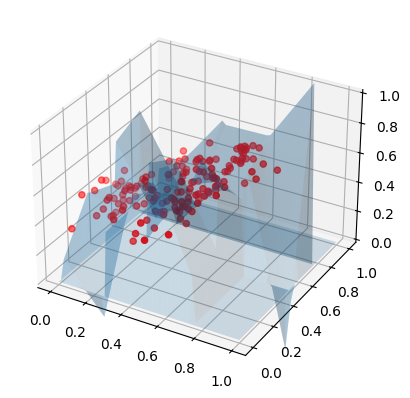

In [20]:
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
x, y = np.meshgrid(x, y)

eq_combined = np.zeros_like(x)
i = 0

for grid in grids:
    t = list(grid.values())[0]
    mask = (t[0][0] < x) & (x < t[1][0]) & (t[0][1] < y) & (y < t[2][1])
    eq_combined[mask] = betastar[i] + betastar[i + 1] * x[mask] + betastar[i+2] * y[mask] + betastar[i+3] * x[mask] * y[mask]
    i += 4
    
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

# Plot the combined piecewise equation
ax.plot_surface(x, y, eq_combined, alpha=0.2)
ax.scatter(data_clean["Economy (GDP per Capita)"], data_clean["Freedom"], data_clean["Happiness Score"], color='red', label='Points')

ax.set_zlim(0,1)

plt.show()

Visually, our least squares approximation looks quite accurate; however we can confirm this hypothesis by calculating the actual least square error;

$$
\mathbb{E} = ||f(x,y)-\textbf{A}(\vec{\beta^*})||
$$

where $\mathbb{E}$ is the vector of least squares for our 158 data points. We will calculate the error along with some useful statistics below.

In [44]:
z_hat = np.matmul(A, betastar)
error = np.array((data_clean["Happiness Score"] - z_hat)**2)
summation = np.sum(error)
mean = np.sum(error)/len(error)

summary = pd.DataFrame({"error" : ["LeastSquare"], "sum": [summation], "mean": [mean], "max": [error.max()], "min": [error.min()]})
summary

,error,sum,mean,max,min
0,LeastSquare,6.919717,0.043796,0.194498,0.000013


Looks like the total square error is only about 6.92, and on-average the approximation is only off by a difference of 0.044. So the approximation is not bad at all! However, this is very different from interpolation; because of the ill-posed interpolation problem, we can no longer meet the requirement that $P_n(x, y) = f(x,y)$. In fact, what we are doing is identical to a technique in statistics known as Linear Regression. Does Linear regression preform better than trying to approximating a 2D bilinear interpolation problem?

## Multivariate Linear Regression

As mentioned above, what we did in the 2D Piecewise Bilinear Interpolation is nearly identical to a multivariate linear regression. The reason is because of the ill-posed linear system. Since the linear system of equations did not meet the requirements for a unique solution we actually cannot meet the requirements for a proper interpolation i.e. not all (x,y)'s satisfies f(x,y) = P(x,y). When this happens, we can only try to get as close as possible to the true solution; we chose to do so by using the method of Least Squares Approximation as proven in theorems (1) and (2). This is exactly, linear regression as it deals with a truth function that one does not know the parameters for so it tries to estimate the truth function by optimizing an objective function; and one of these objective functions just happens to be the Least Squares Error.

The Equation we are trying to solve:

$$
Z = \beta _0 + \beta _1X + \beta _2Y
$$

This is our truth function; however, we can never solve for the truth function because of random error in data; we can only approximate the expected function,

$$
\mathbb{E}[z_i] = \mathbb{E}[\beta _0 + \beta _1x_i + \beta _2y_i + \epsilon _i] \newline
\text{by linearity of the expectation }\quad \hat{z}_i = \mathbb{E}[\beta _0 + \beta _1x_i + \beta _2y_i] + \mathbb{E}[\epsilon _i] \newline
\hat{z}_i = \hat{\beta _0} + \hat{\beta _1}x_i + \hat{\beta _2}y_i + 0
$$

where $\epsilon _i$ is a normally distributed random variable with mean 0 ($\mathbb{E}[\epsilon _i] = 0$) and some variance $\sigma^2$ that is not dependent on $X$ and $z_i, x_i, y_i$ are random variables pulled from the true distributions of $X$, $Y$, and $Z$ a.k.a. samples.

For this problem, we have access to 158 samples from the 2015 World Happiness Record:
$$
\overrightarrow{\text{GDP}} = (x_1, x_2, ... x_{158}), \quad \overrightarrow{\text{Freedom}} = (y_1, y_2, ..., y_{158}), \quad
\overrightarrow{\text{Happiness}} = (z_1, z_2, ..., z_{158}),
$$



Then, rewriting in matrix notation we get the following;

$$
\hat{Z} = \textbf{A}\vec{\hat{\beta}}
$$

where $\textbf{A}$ is the matrix,

$$
\textbf{A} = \begin{pmatrix}
1 & x_1 & y_1\\
1 & x_2 & y_2 \\
\vdots & \vdots & \vdots\\
1 & x_n & y_n
\end{pmatrix}
$$

and $\vec{\hat{\beta}}$ is a vector of coefficients (in the case of equation i),

$$
\vec{\hat{\beta}} = \begin{pmatrix}
\hat{\beta} _0\\
\hat{\beta}_1\\
\hat{\beta} _2
\end{pmatrix}
$$

Once again, by theorem (2) we know we can find a solution for $\vec{\hat{\beta}}$ with the following expression;

$$
\vec{\hat{\beta}} = (\textbf{A}^T\textbf{A})^{-1}\textbf{A}^T\hat{Z}
$$